# Проект Bank Marketing

Автор: Олег Акимов (Slack: @Oleg)

## 0. Постановка задачи

В ходе проекта решается задача прогнозирования положительного отклика (срочный вклад) на прямые звонки из банка.  
По-сути, задача является задачей банковского скоринга, т.е. по характеристикам клиента (потенциального клиента), предсказывается его поведение (невозврат кредита, желание открыть вклад и т.д.). В департаментах рисков банков существуеют строгие требования к интерпретируемости модели, поэтому я хочу рассмотреть 2 решения: "банковское" и свободное. Задача обзвона клиентов не является задачей определения риска дефолта, поэтому на неё не накладывается условие интерпретируемости, однако задача схожая, и думаю интересно на ее примере показать решение с ограничением (интерпретируемость).

Источник данных UCI: https://archive.ics.uci.edu/ml/datasets/bank+marketing

## 1. Описание набора данных и признаков

Датасет содержит 41188 объектов, для кадого из которых задан 21 признак, в том числе 1 целевой. 

Рассмотрим по порядку все имеющиеся признаки:  
1) **age** - возраст потенциального клиента в годах  
2) **job** - профессия (Возможны следующие значения: *admin., blue-collar, entrepreneur, housemaid, management, retired, self-employed, services, student, technician, unemployed, unknown*)  
3) **marital** - семейное положение (Значения: *divorced, married, single, unknown*)  
4) **education** - образование (Значения: *basic.4y, basic.6y, basic.9y, high.school, illiterate, professional.course, university.degree, unknown*)  
5) **default** - есть ли дефолт по кредиту (Значения: *no, yes, unknown*)  
6) **housing** - есть ли кредит на жильё (Значения: *no, yes, unknown*)  
7) **loan** - есть ли потребительский кредит (Значения: *no, yes, unknown*)  
8) **contact** - способ связи c потенциальным клиентом (Значения: *cellular, telephone*)  
9) **month** - номер месяца, когда был крайний контакт с клиентом (Значения: *jan, feb, mar, ... , nov, dec*)  
10) **day_of_week** - день недели, когда был крайний контакт с клиентом (Значения: *mon, tue, wed, thu, fri*)  
11) **duration** - продолжительность крайнего звонка клиенту (Имеется ввиду, звонок, результат которого мы прогнозируем, в секундах)  
12) **campaign** - количество контактов с данным клиентом в течение текущей компании  
13) **pdays** - количество дней, прошедшее с предыдущего контакта (999 для новых клиентов)  
14) **previous** - количество контактов с данным клиенто до текущей компании  
15) **poutcome** - результат предыдущей маркетинговой компании (Значения: *failure, nonexistent, success*)  
16) **emp.var.rate** - коэффициент изменения занятости - квартальный показатель  
17) **cons.price.idx** - индекс потребительских цен - месячный показатель  
18) **cons.conf.idx** - индекс доверия потребителей - ежемесячный показатель  
19) **euribor3m** - euribor 3-месячный курс - дневной индикатор  
20) **nr.employed** - количество сотрудников - квартальный показатель  

Целевой признак:

21) **y** - подписал ли клиент срочный вклад (Значения: *yes, no*)

## 2-3. Первичный анализ данных и первичный визуальный анализ данных

Загрузим необходимые библиотеки:

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split, StratifiedKFold
from imblearn.over_sampling import RandomOverSampler
from sklearn import preprocessing
from sklearn.model_selection import validation_curve
from sklearn.svm import SVC
import time
from sklearn.linear_model import SGDClassifier
from xgboost import XGBClassifier
import warnings
from sklearn.tree import DecisionTreeClassifier
warnings.filterwarnings('ignore')

Загрузим данные из файла и зададим параметры вывода датафрейма, чтобы все колонки было видно.

In [2]:
raw_data = pd.read_csv('bank-additional-full.csv', header = 0, sep = ';')
data = raw_data.copy()
pd.set_option('display.max_columns', 100)

Посмотрим на размер загруженного датасета:

In [3]:
data.shape

(41188, 21)

Посмотрим, на содержимое датафрейма:

In [4]:
data.head(5)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


Проверим, есть ли в данных отсутствующие значения:

In [5]:
data.isnull().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

Как видим, данные полные, пропусков нет, поэтому нет необходимости заполнять пропуски.  
Далее проверим данные на выбросы. Для начала сравним минимальное и максимальное значение со средним (для численных признаков):

In [6]:
data.describe(include = ['int64', 'float64'])

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


В целом, по этим данным, нельзя сказать, что в данных есть откровенные выбросы. Однанако, такой проверки недостаточно,  
желательно ещё посмотреть графики зависимости целевого признака от каждого из признако, но это мы сделаем чуть позже,  
когда будем визуализировать признаки и зависимости.  

Далее посмотрим на распределения числовых признаков. Для этого воспользуемся библиотекой Seaborn.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000154D83AD898>,
      dtype=object)

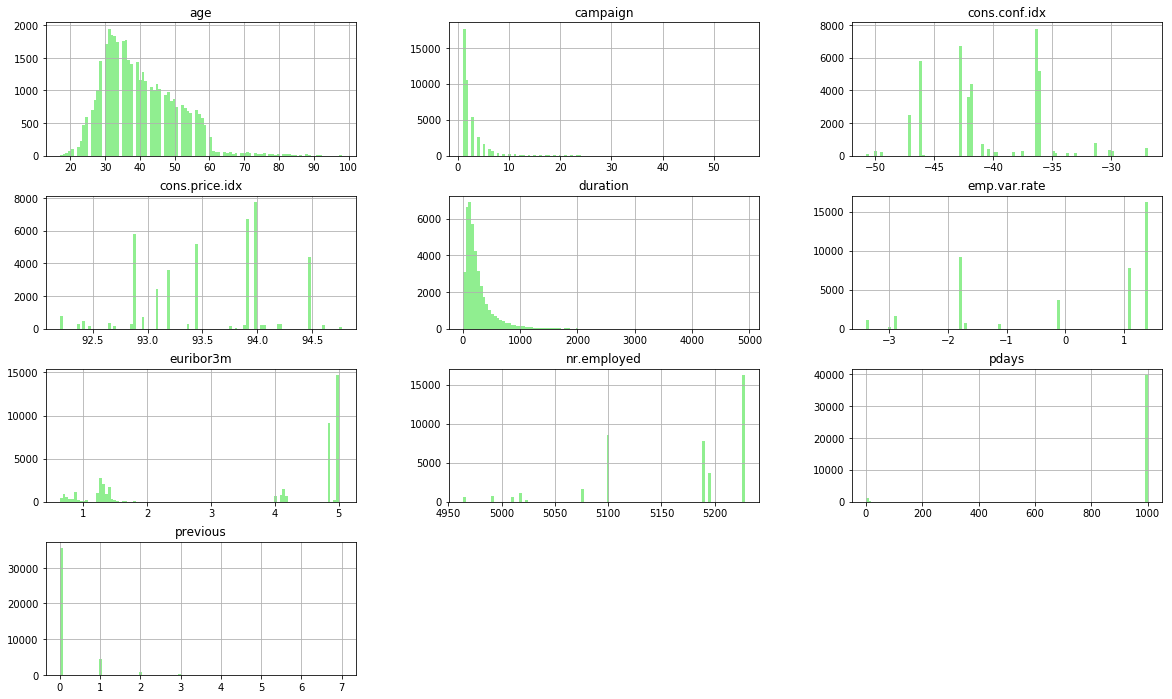

In [7]:
categorial = []
numerical = []
for feature in data.columns:
    if data[feature].dtype == object:
        categorial.append(feature)
    else:
        numerical.append(feature)

data[numerical].hist(figsize=(20,12), bins=100, color='lightgreen')

Из гистограмм мы видим, что **для каждого численного признака есть одно или несколько доминирующих отрезков значений**,  
из-за чего мы получили ярко выраженные пики.  

Далее осмотрим на категориальные признаки:

In [8]:
data.describe(include = ['object'])

,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome,y
count,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188
unique,12,4,8,3,3,3,2,10,5,3,2
top,admin.,married,university.degree,no,yes,no,cellular,may,thu,nonexistent,no
freq,10422,24928,12168,32588,21576,33950,26144,13769,8623,35563,36548


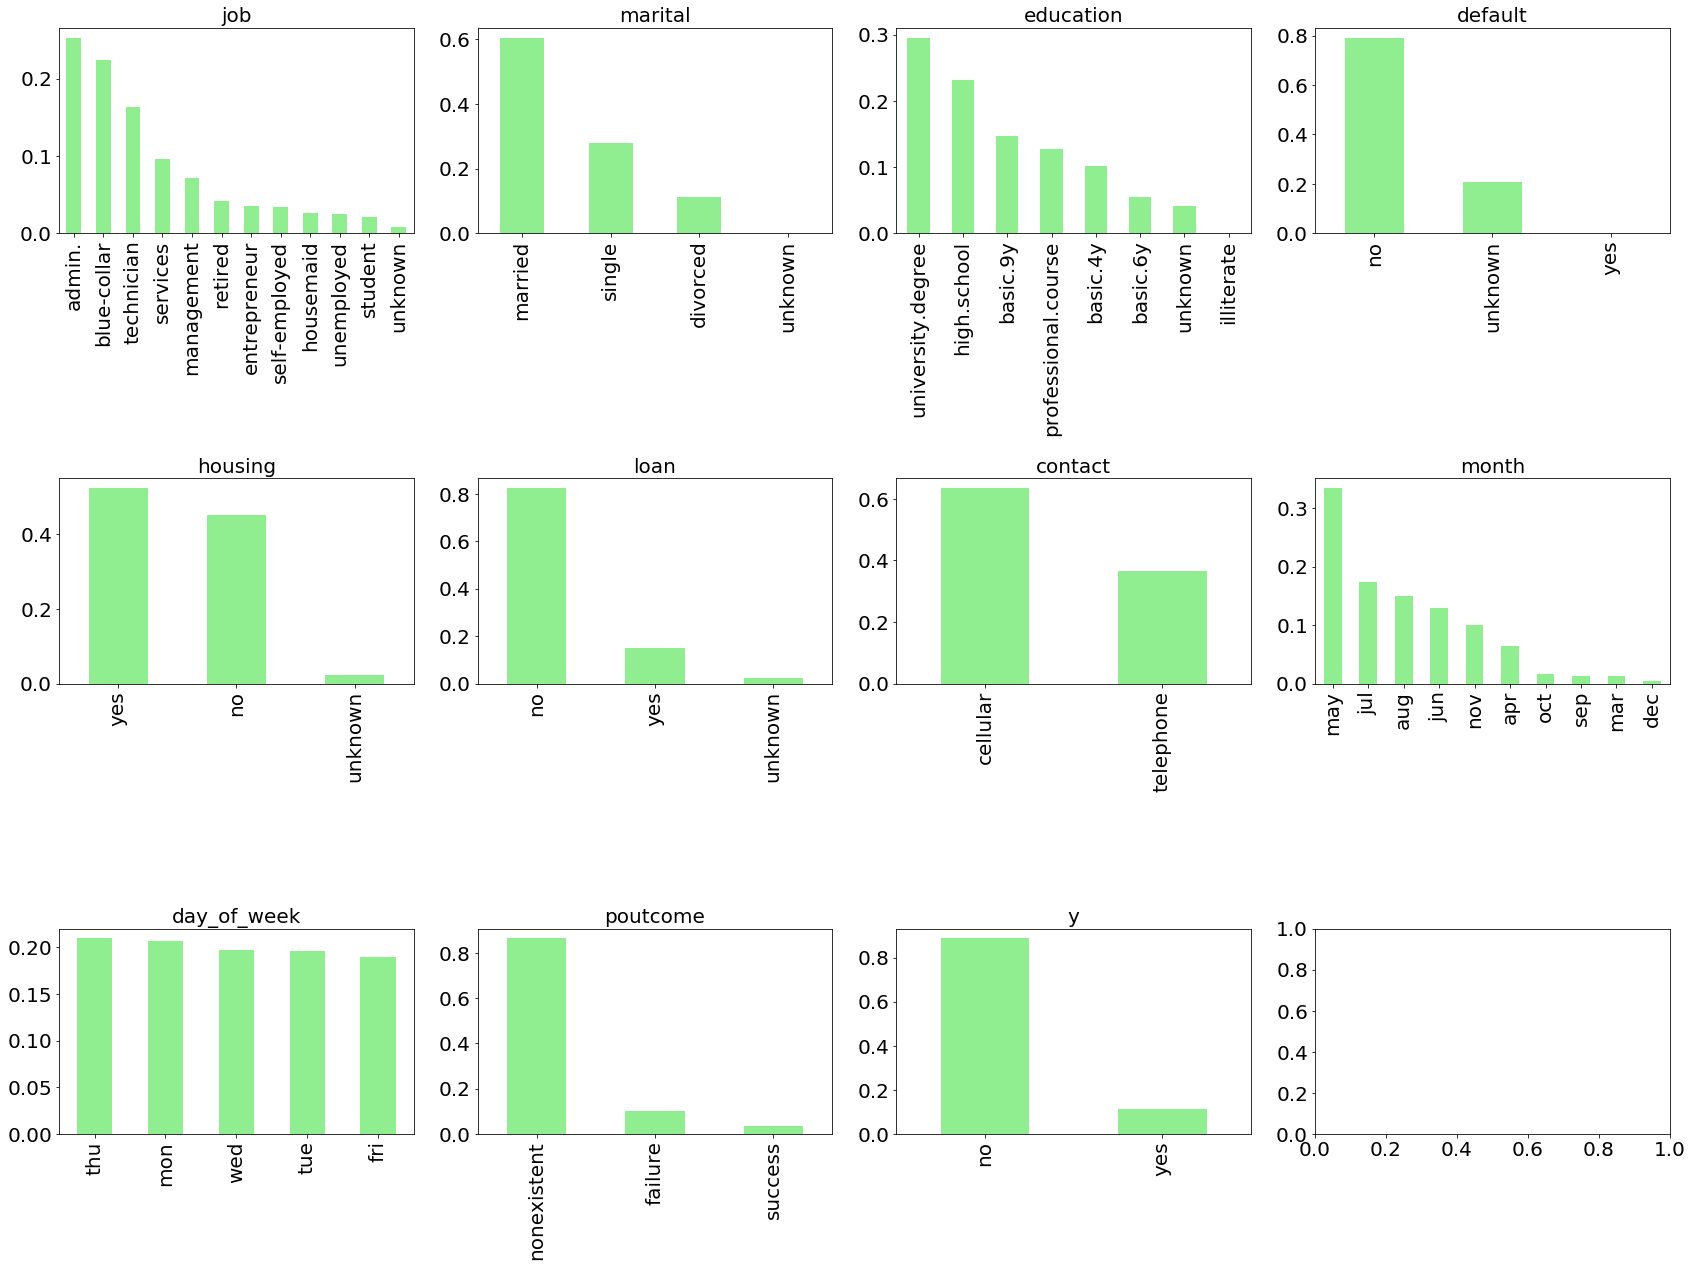

In [14]:
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['font.size'] = 20

fig, axes = plt.subplots(ncols=4, nrows = 3, figsize=(24, 18))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.4)

for i in range(len(categorial)):
    data[categorial[i]].value_counts(normalize=True).plot(kind='bar', label=categorial[i], ax=axes[i//4, i%4], color='lightgreen')
    axes[i//4, i%4].set_title(categorial[i])
plt.tight_layout()

Как видим, для многих признаков, какая-то из групп привалирует, например, в датасете более половины клиентов женаты/замужем. 

Помимо этого мы видим, что целевой признак несбалансирован. **Количество положительных исходов существенно ниже, чем отрицательных**, что вполне естественно для телефонного маркетинга. Вследствие этого, возникает проблема с тем, что многие методы чувствительны к несбалансированности признаков. Данную проблему мы дальше постораемся решить.

Посмотрим на матрицу корреляции (для числовых признаков):

In [15]:
correlation_table = data.corr()
correlation_table

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
age,1.000000,-0.000866,0.004594,-0.034369,0.024365,-0.000371,0.000857,0.129372,0.010767,-0.017725
duration,-0.000866,1.000000,-0.071699,-0.047577,0.020640,-0.027968,0.005312,-0.008173,-0.032897,-0.044703
campaign,0.004594,-0.071699,1.000000,0.052584,-0.079141,0.150754,0.127836,-0.013733,0.135133,0.144095
pdays,-0.034369,-0.047577,0.052584,1.000000,-0.587514,0.271004,0.078889,-0.091342,0.296899,0.372605
previous,0.024365,0.020640,-0.079141,-0.587514,1.000000,-0.420489,-0.203130,-0.050936,-0.454494,-0.501333
emp.var.rate,-0.000371,-0.027968,0.150754,0.271004,-0.420489,1.000000,0.775334,0.196041,0.972245,0.906970
cons.price.idx,0.000857,0.005312,0.127836,0.078889,-0.203130,0.775334,1.000000,0.058986,0.688230,0.522034
cons.conf.idx,0.129372,-0.008173,-0.013733,-0.091342,-0.050936,0.196041,0.058986,1.000000,0.277686,0.100513
euribor3m,0.010767,-0.032897,0.135133,0.296899,-0.454494,0.972245,0.688230,0.277686,1.000000,0.945154
nr.employed,-0.017725,-0.044703,0.144095,0.372605,-0.501333,0.906970,0.522034,0.100513,0.945154,1.000000


Визуализируем матрицу корреляции:

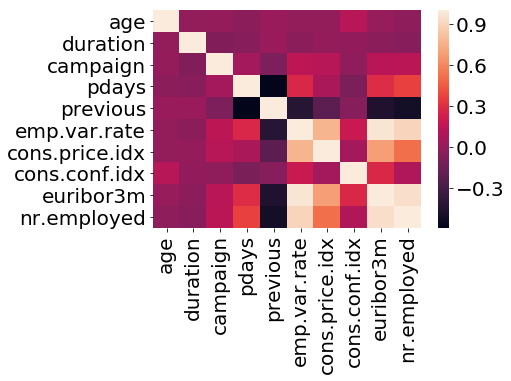

In [16]:
sns.heatmap(correlation_table)

Как видно из таблицы и тепловой карты **euribor3m и nr.employed сильно коррелируют с emp.var.rate**, впоследствии, на этапе отбора признаков мы их удалим, когда будем отбирать признаки.

Целевой признак показывает положительный ли результат телефонного звонка в ходе маркетинговой компании.  
Обозначим положительный исход как 1, отрицательный как 0:

In [17]:
data['y'] = data['y'].map({'yes': 1, 'no': 0})

Посмотрим на визуализированные зависимости вещественных признаков от целевого признака:

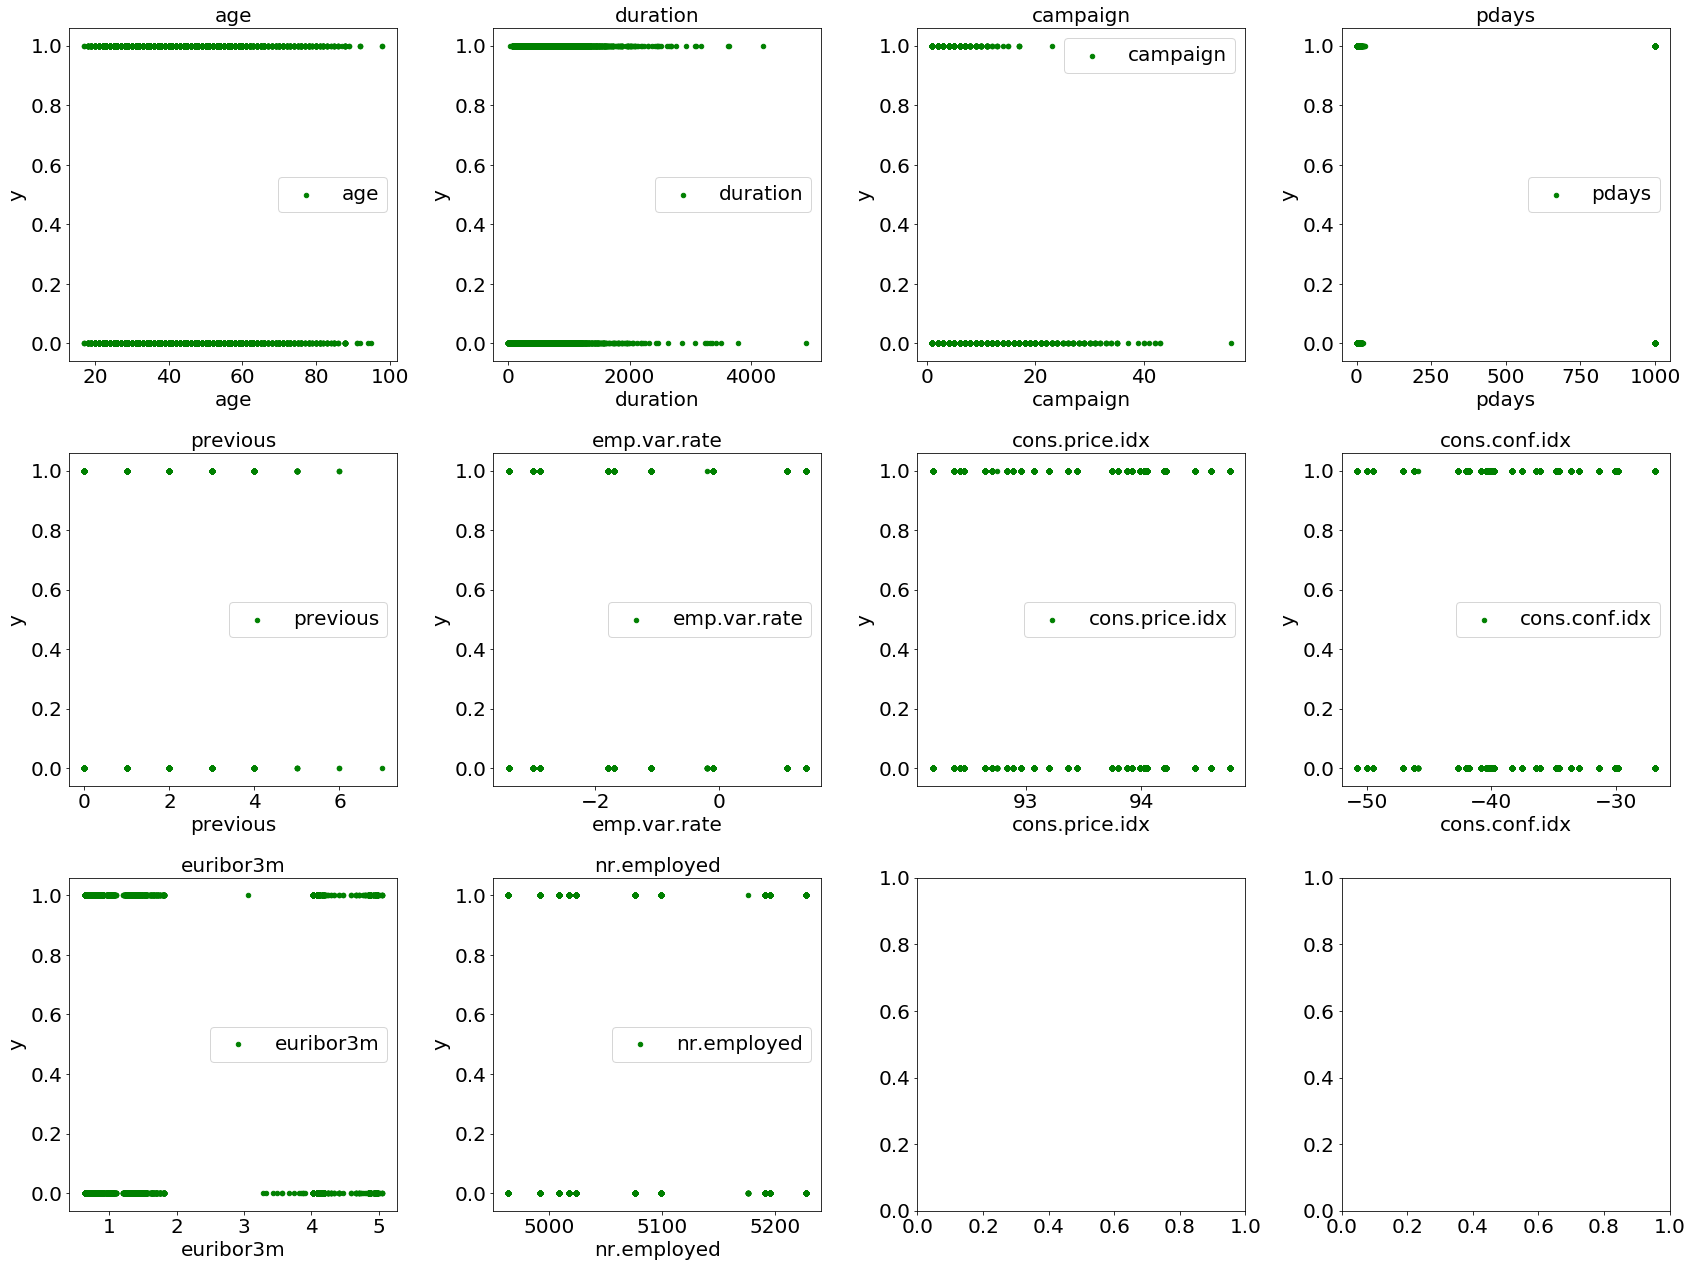

In [19]:
fig, axes = plt.subplots(ncols=4, nrows = 3, figsize=(24, 18))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.4)

for i in range(len(numerical)):
    data.plot(x=numerical[i], y = 'y', label=numerical[i], ax=axes[i//4, i%4], kind='scatter', color='green')
    axes[i//4, i%4].set_title(numerical[i])
plt.tight_layout()

Как видим, есть точки, которые можно интерпретировать как выбросы есть, однако, я бы не спешил их удалять, т.к. мне они не кажутся выбросами в чистом виде. Т.е. это врядли ошибки и выбросы слишком сильные, пока я их оставлю. К тому же, для начала я намерен использовать RandomForest, а деревья, как известно, устойчивы к выбросам.

Категориальные признаки необходимо сделать числовыми, для этого я использую LabelEncoder. OneHotEncoder не использую, т.к. для категориальных признаков в дальнейшем буду считать WOE (см. дальше), поэтому нам неважно как занумеровывать категории.

In [20]:
categorial.remove('y')
data[categorial] = data[categorial].apply(LabelEncoder().fit_transform)

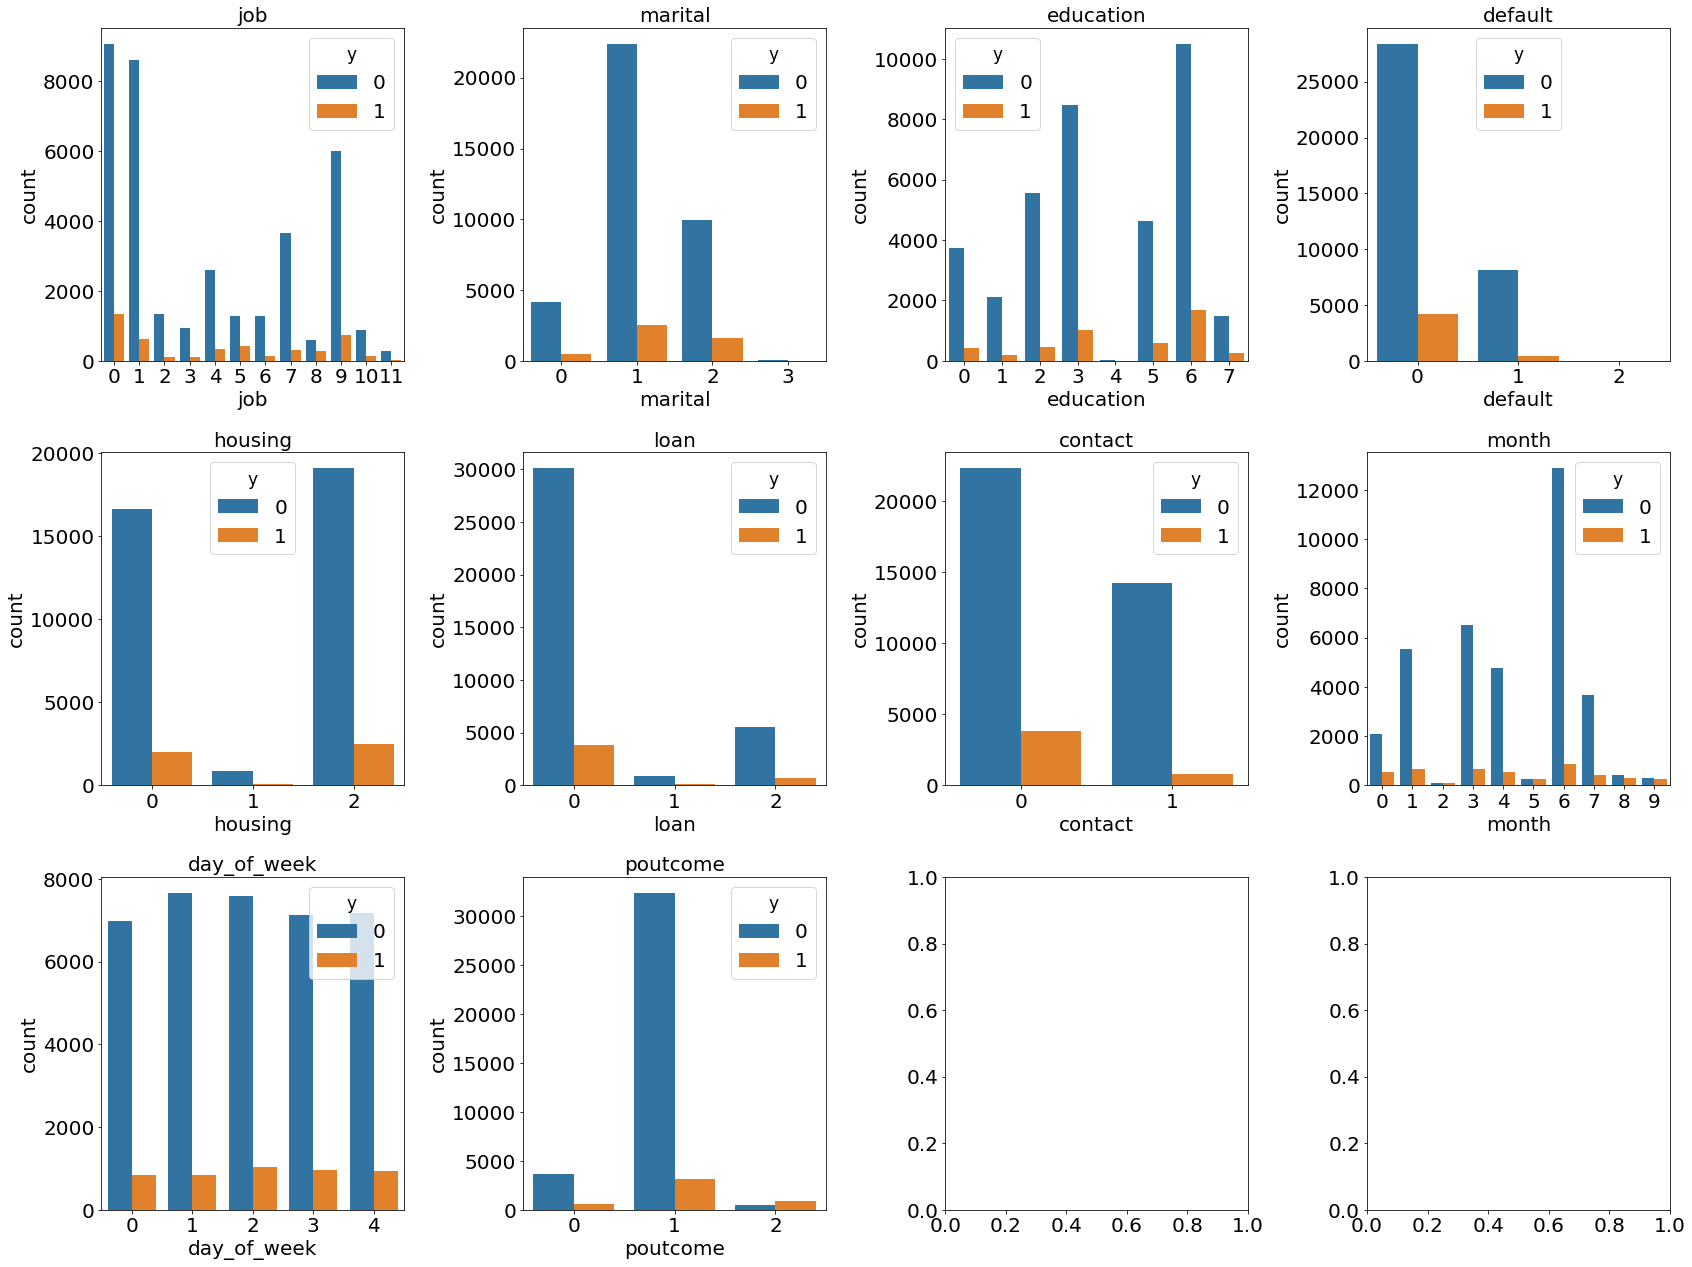

In [22]:
fig, axes = plt.subplots(ncols=4, nrows = 3, figsize=(24, 18))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.4)

for i in range(len(categorial)):
    sns.countplot(x=categorial[i], hue='y', data=data, ax=axes[i//4, i%4])
    axes[i//4, i%4].set_title(categorial[i])

plt.tight_layout()

Из данных графиков видно некоторые зависимости, но лучше посмотреть в несколько другом виде.  
Визуализируем **долю положительных откликов** по группам:

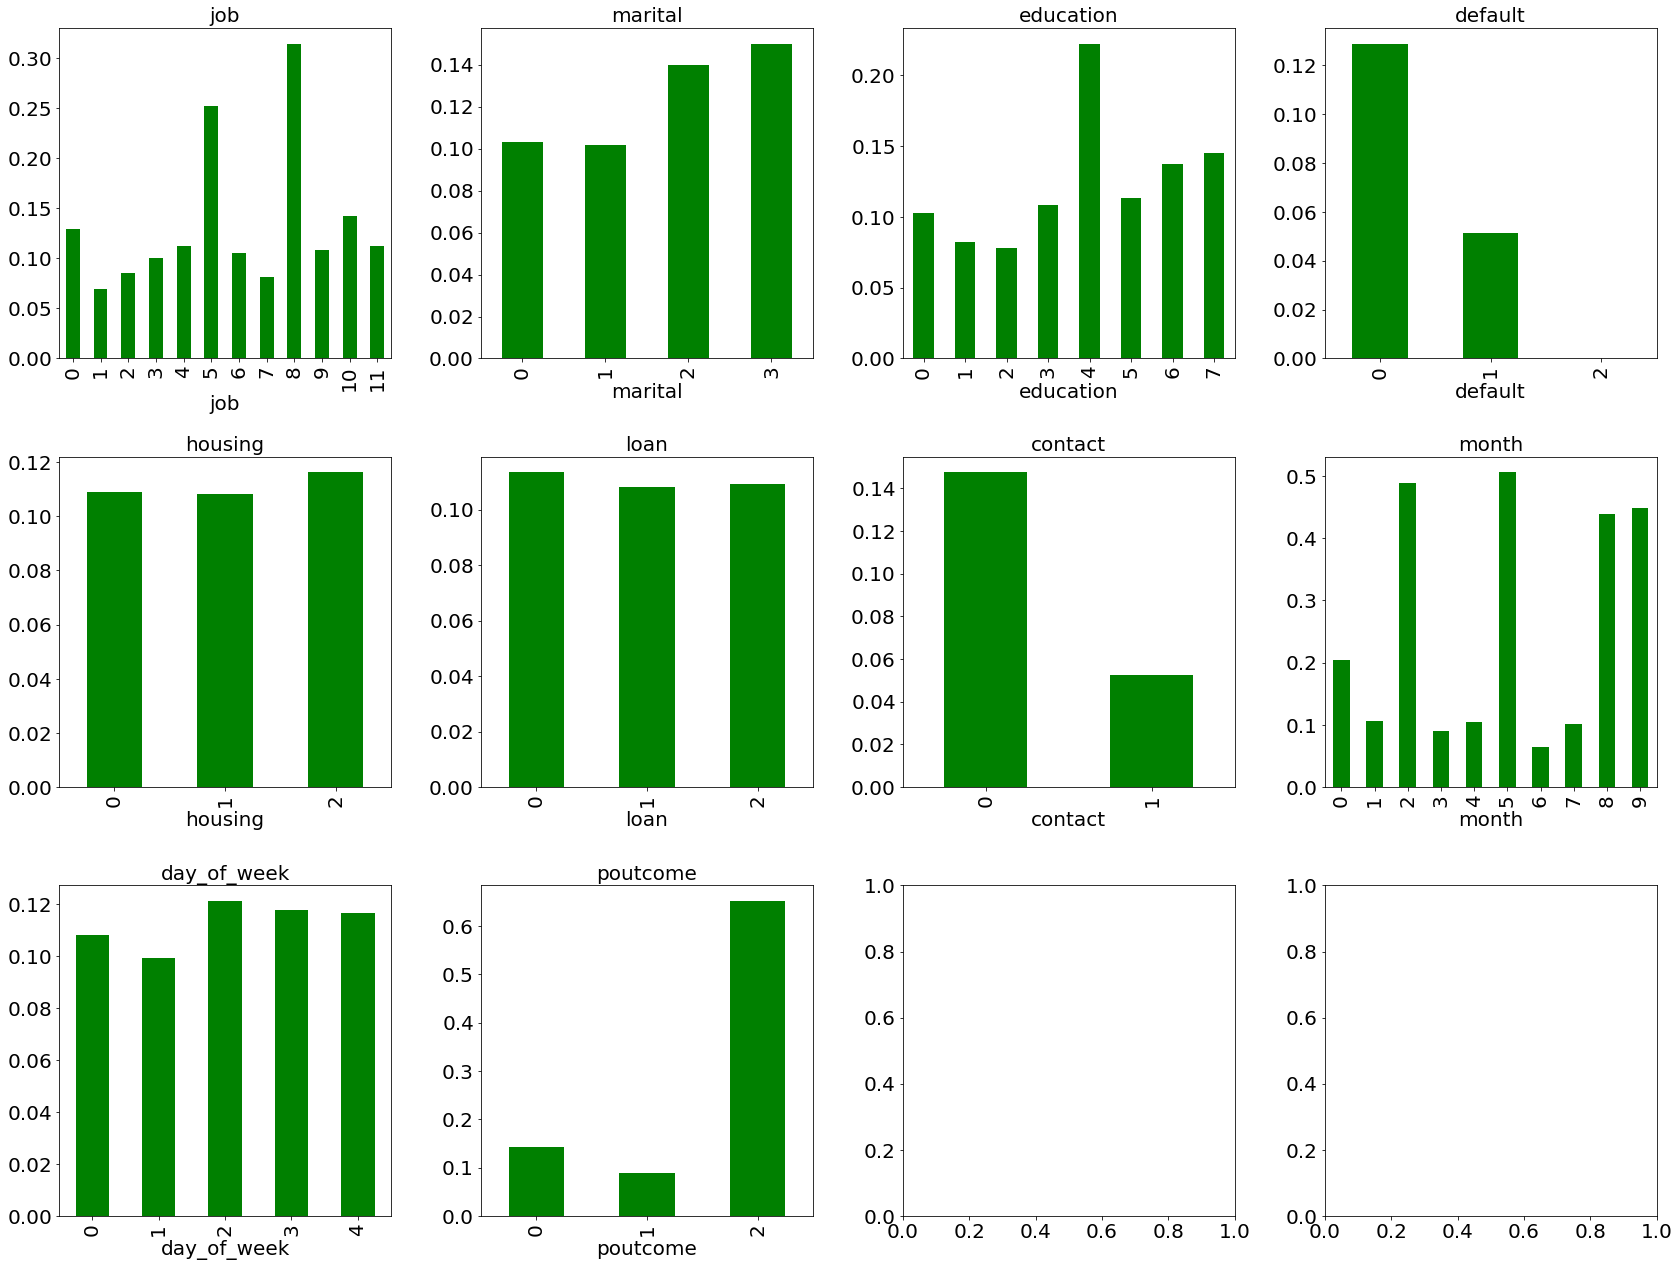

In [24]:
fig, axes = plt.subplots(ncols=4, nrows = 3, figsize=(24, 18))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.4)

for i in range(len(categorial)):
    data.groupby(categorial[i])['y'].mean().plot(kind='bar', ax=axes[i//4, i%4], color='green')
    axes[i//4, i%4].set_title(categorial[i])

plt.tight_layout()

В таком виде, графики уже более интересные. Дак мы видим, для многих признаков, шанс положительного отклика существенно выше.  
Как я уже говорил, я панирую использовать WOE для работы с категориальными признаками.  
Помимо этого, исходя из данных графиков, напрашивается идея сделать более укрупненные категории. Например для образования объединить категории следующим образом:  
1) 0, 3, 5  
2) 1, 2  
3) 6, 7  
4) 4  
Однако, прелесть WOE в том, что как раз для значений признака, для которых доля положительных откликов сходная, будут близки и значения WOE. Поэтому, из графиков понятно, что применение WOE в данной задаче обосновано и желательно. 

Также мы видим, что признаки **housing**, **loan** и **day_of_week** врядли нам чем-то помогут, т.к. судя по графикам, доля положительных откликов от них практически не зависит. *Осторожно, спойлеры.* Далее мы их удалим, но перед этим посмотрим на них с точки зрения Information Value и увидим, что они действительно неинформативны.

## 4. Инсайты   
   
Пропусков в данных у нас нет, явных выбросов, которые стоило бы вырезать, на мой взгляд тоже нет. 
   
**euribor3m** и **nr.employed** сильно коррелируют с **emp.var.rate**.   
Напомню, **emp.var.rate** - коэффициент изменения занятости - квартальный показатель, **euribor3m** - euribor 3-месячный курс - дневной индикатор, **nr.employed** - количество сотрудников - квартальный показатель. Корреляция изменения занятости и собственно количества занятых вопросов не вызывает, а вот корреляция с Euribor (Euro Interbank Offered Rate, европейская межбанковская ставка предложения) - это интересно. Межбанковская ставка - это один из основных макропараметров экономики государства, т.е. влияет на темпы роста экономики, которые естественным образом влияют на занятость. Логично, но такая сильная корреляция подозрительна :). Слишком быстрый отклик рынка труда.

## 5. Выбор метрики

Цель банка состоит в том, чтобы снизить затраты на обзвон всех клиентов, сузив группу обзвона до той группы, для которой наиболее высока вероятность положительного отклика. Для банка важно снизить количество звонков не потеряв при этом клиентов, поэтому наиболее **критичными для банка являются ошибки FalseNegative**, т.к. банк теряет клиентов. Затраты на лишний звонок ниже, чем убыток от потерянного клиента. Исходя из этого, предпочитетльной метрикой будет **Recall**,  которая показывает, какую долю объектов положительного класса из всех объектов положительного класса нашел алгоритм. Однако, **Recall** метрика слишком "однобокая", т.к. стимулирует модель ставить всем объектам метки "1". Поэтому, более предпочтительным я считаю использование **ROC-AUC**, но при этом считаю важным следить отдельно за значением **Recall**. Ниже проиллюстрируем, почему **не стоит использовать Acuracy**

Что будет, если мы всем объектам поставим метки "0"?

In [25]:
print ('Accuracy = ', round((1 - data['y'].mean())*100, 1))
print ('Recall = ', round(recall_score(data['y'], [0]*len(data['y'])), 1))
print ('ROC-AUC = ', round(roc_auc_score(data['y'], [0]*len(data['y'])), 1))

Accuracy =  88.7
Recall =  0.0
ROC-AUC =  0.5


Таким образом, мы имеем точность модели 88.7%, однако банк имеет нулевую прибыль, т.к. обзвон потенциальных клиентов не производился.  
Основная причина такой ситуации в том, что целевые классы очень несбалансированны, положительных откликов всего 11.3%,  
поэтому мы предпочтём **ROC-AUC**

In [26]:
data['y'].value_counts(normalize=True).apply(lambda x: round(x*100, 1))

0    88.7
1    11.3
Name: y, dtype: float64

А если мы всем объектам поставим метки "1"?

In [27]:
print ('Accuracy = ', round((data['y'].mean())*100, 1))
print ('Recall = ', round(recall_score(data['y'], [1]*len(data['y'])), 1))
print ('ROC-AUC = ', round(roc_auc_score(data['y'], [1]*len(data['y'])), 1))

Accuracy =  11.3
Recall =  1.0
ROC-AUC =  0.5


Как мы видим, recall максимальный, но при этом мы обзваниваем всех

## 6. Выбор модели

Как я говорил в начале своей работы, я разделю решение на 2 части:  
**1) "Банковское"**: логистическая регрессия + WOE. Выбор обоснован тем, что Логистическая Регрессия хорошо интерпретируема и используется в реальном банковском моделировании рисков. Однако, Логистическая Регрессия не работает с категориальными признаками, вернее сказать, что работает, но для этого значения категориальных признаков должны быть сравнимы. В том числе для этого вводится понятие WOE (Weight of evidence).   
**2) Свободное от ограничений решение**: в нем я хочу исследовать RandomForest и XGBoost. Делаю ставку на RandomForest, т.к. он устойчив к выбросам (которые я не удалял, т.к. не уверен, что они не важны) и т.к. многие признаки категориальные, значит деревья должны себя показать лучше на таких признаках. Данные модели будут тоже использоваться в сочетании с расчетом WOE (см. конец пункта 4). Также попробую XGBoost на деревьях в соответствии с той же логикой. И в итоге, попробую их объединить.

## 7. Предобработка данных

Удалим признаки **euribor3m** и **nr.employed**, которые сильно коррелируют с **emp.var.rate** (см. пункт 2-3)

In [28]:
data.drop(['euribor3m', 'nr.employed'], axis=1, inplace=True)

Удалим признак **duration**, т.к. он показывает продолжительность разговора, необходимость которого мы хотим предсказать

In [29]:
data.drop(['duration'], axis=1, inplace=True)

**Посчитаем WOE**:

![title](../../img/WOE.jpg)

Функция расчёта **Information Value**:

In [30]:
def Information_Value(x, y):
    df = pd.DataFrame({'x': x, 'y': y})
    good = df.groupby('x')['y'].sum() / np.sum(df['y'])
    bad = (df.groupby('x')['y'].count() - df.groupby('x')['y'].sum()) / (len(df['y']) - np.sum(df['y']))
    WOE = np.log((good+0.000001) / bad)
    IV = (good - bad)*WOE
    return IV.sum()

Функция расчёта **WOE**:

In [31]:
def WOE(x, y):
    df = pd.DataFrame({'x': x, 'y': y})
    good = df.groupby('x')['y'].sum() / np.sum(df['y'])
    bad = (df.groupby('x')['y'].count() - df.groupby('x')['y'].sum()) / (len(df['y']) - np.sum(df['y']))
    WOE = np.log((good+0.000001)/ bad)
    WOE = pd.Series(WOE).to_dict()
    return x.apply(lambda x: WOE.get(x))

WOE можно считать для значений признака, однако, учитывая формулу WOE, делать это для вещественных признаков не очень правильно. Лучше разбить диапазон значений на интервалы, закодировать их и посчитать WOE. Отсюда вытекает задача, как оптимально разбить значения признаков на интервалы. Для решения этой задачи, я решил для каждого признака обучать DecisionTreeClassifier и из него получать границы разбиение признака, при которых score максимальный.

In [32]:
# Функция, которая возвращает границы разбиений
def get_bondaries(x_bondaries, y_bondaries):
    parameters = {'max_depth':[x for x in range(1, 21)], 'min_samples_leaf': [5, 10, 20, 30, 50, 70, 100, 150, 200, 300, 400, 500, 1000, 2000, 5000, 10000, 20000]}
    dtc = DecisionTreeClassifier(random_state=17)
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)
    clf = GridSearchCV(dtc, parameters, scoring='roc_auc', cv=skf)
    clf.fit(pd.DataFrame(x_bondaries), y_bondaries)
    print('Best parameters for DT: ', clf.best_params_)
    print('ROC_AUC score: ', round(clf.best_score_, 4))
    tree = clf.best_estimator_
    tree.fit(pd.DataFrame(x_bondaries), y_bondaries)
    print('Boundaries: ', np.sort([x for x in tree.tree_.threshold if x!=-2]))
    return np.sort([x for x in tree.tree_.threshold if x!=-2])

Расчитываем границы разбиений для каждого признака. Посмотрим параметры дерева, которое делит признаки на интервалы, а так же на само разбиение.

In [33]:
bondaries = dict()
for col in data.columns:
    if col != 'y':
        print (col)
        bondaries[col] = get_bondaries(data[col], data['y'])
        print ('--------------')

age
Best parameters for DT:  {'max_depth': 9, 'min_samples_leaf': 500}
ROC_AUC score:  0.6048
Boundaries:  [23.5 25.5 26.5 27.5 28.5 29.5 30.5 31.5 32.5 33.5 34.5 35.5 36.5 37.5
 38.5 46.5 47.5 48.5 49.5 50.5 51.5 52.5 53.5 54.5 55.5 56.5 57.5 58.5
 60.5]
--------------
job
Best parameters for DT:  {'max_depth': 6, 'min_samples_leaf': 5}
ROC_AUC score:  0.6083
Boundaries:  [ 0.5  1.5  2.5  3.5  4.5  5.5  6.5  7.5  8.5  9.5 10.5]
--------------
marital
Best parameters for DT:  {'max_depth': 2, 'min_samples_leaf': 70}
ROC_AUC score:  0.5394
Boundaries:  [0.5 1.5 2.5]
--------------
education
Best parameters for DT:  {'max_depth': 3, 'min_samples_leaf': 5}
ROC_AUC score:  0.5573
Boundaries:  [0.5 2.5 3.5 5.5 6.5]
--------------
default
Best parameters for DT:  {'max_depth': 1, 'min_samples_leaf': 5}
ROC_AUC score:  0.5639
Boundaries:  [0.5]
--------------
housing
Best parameters for DT:  {'max_depth': 2, 'min_samples_leaf': 5}
ROC_AUC score:  0.5087
Boundaries:  [0.5 1.5]
--------------
l

In [34]:
# Функция каторая режет признак на интервалы и кодирует их
def splitter(x, col_bondaries):
    for i in range(len(col_bondaries)):
        if i>0:
            if x>col_bondaries[i-1] and x<=col_bondaries[i]:
                return i
        if i==0:
            if x<=col_bondaries[i]:
                return i
        if i==len(col_bondaries)-1:
            if x>col_bondaries[i]:
                return i+1

Считаем WOE для признаков:

In [35]:
data_woe = pd.DataFrame()
for col in data.columns:
    if col != 'y' and col!='default' and col!='previous':
        data_woe[col] = data[col].apply(lambda x: splitter(x, bondaries[col]))
        data_woe[col] = WOE(data_woe[col], data['y'])
    if col=='default' or col=='previous':
        data_woe[col] = data[col]

Посмотрим на **Information Value** категориальных признаков:

In [36]:
for feature in data_woe.columns:
    print('IV of ', feature, ' = ', Information_Value(data_woe[feature], data['y']), '\n')

IV of  age  =  0.24541173287071089 

IV of  job  =  0.18871280550635278 

IV of  marital  =  0.028215407005004245 

IV of  education  =  0.04810420097260354 

IV of  default  =  0.12812942460056045 

IV of  housing  =  0.0013829926677970496 

IV of  loan  =  0.0002653966141089776 

IV of  contact  =  0.2516619082858709 

IV of  month  =  0.45112023815849417 

IV of  day_of_week  =  0.006481446978382145 

IV of  campaign  =  0.07044897775332107 

IV of  pdays  =  0.5616608969205427 

IV of  previous  =  0.35048518178637994 

IV of  poutcome  =  0.5476716036799131 

IV of  emp.var.rate  =  1.0697493268709626 

IV of  cons.price.idx  =  1.3133495403026403 

IV of  cons.conf.idx  =  1.3097831341498016 



Сравнивая Information value, видим, что признаки **housing**, **loan** и **day_of_week** являются неинформативными, поэтому мы их можем удалить. Кстати говоря, это же мы видели, когда строили графики, показывающие долю положительных откликов в зависимости от значения признака.

In [37]:
data_woe.drop(['housing', 'loan', 'day_of_week'], axis=1, inplace=True)

## 8. Кросс-валидация и настройка гиперпараметров

Отложим выборку для теста:

In [38]:
df, df_test, y, y_test = train_test_split(data_woe, data['y'], test_size=0.3, stratify=data['y'], random_state=17)

## 8.1 Логистическая регрессия

Подберем параметры с помощью **GridSearchCV**:

In [39]:
parameters = {'penalty':['l1', 'l2'], 'C':[0.12, 0.11, 0.1, 0.09, 0.08, 0.07, 0.06, 0.05, 0.04, 0.03, 0.02, 0.01], 'class_weight':[None, 'balanced']}
LR = LogisticRegression(random_state=17, n_jobs=-1)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)
clf_lr = GridSearchCV(LR, parameters, scoring='roc_auc', cv=skf)
clf_lr.fit(data_woe, data['y'])
print('Best parameters: ', clf_lr.best_params_)
print('ROC_AUC score: ', round(clf_lr.best_score_, 4))

Best parameters:  {'C': 0.04, 'class_weight': None, 'penalty': 'l1'}
ROC_AUC score:  0.7958


Теперь посмотрим качество на **отложенной выборке** и заодно оценим время работы **Logit** с наилучшими параметрами:

In [40]:
start = time.time()
LR_control = LogisticRegression(C=0.04, penalty='l1')
LR_control.fit(df, y)
print('ROC_AUC on Control data: ', round(roc_auc_score(y_test, LR_control.predict_proba(df_test)[:,1]), 4))
print('Overall time: ', round(time.time()-start, 1))

ROC_AUC on Control data:  0.7952
Overall time:  3.3


## 8.2 Случайный лес

Теперь попробуем **RandomForest**:

In [41]:
parameters = {'n_estimators':[280, 290, 300, 310, 320, 330], 'max_depth':[8, 9, 10, 11, 12, 15], 'min_samples_leaf': [1, 10, 30, 50, 100]}
RFC = RandomForestClassifier(random_state=17, n_jobs=-1)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)
clf_rfc = GridSearchCV(RFC, parameters, scoring='roc_auc', cv=skf)
clf_rfc.fit(data_woe, data['y'])
print('Best parameters: ', clf_rfc.best_params_)
print('ROC_AUC score: ', round(clf_rfc.best_score_, 4))

Best parameters:  {'max_depth': 9, 'min_samples_leaf': 1, 'n_estimators': 290}
ROC_AUC score:  0.7978


Результат на **отложенной выборке** с наилучшими параметрами:

In [42]:
start = time.time()
RF_control = RandomForestClassifier(max_depth=9, n_estimators=290)
RF_control.fit(df, y)
print('ROC_AUC on Control data: ', round(roc_auc_score(y_test, RF_control.predict_proba(df_test)[:,1]), 4))
print("Overall time:", round(time.time()-start, 1))

ROC_AUC on Control data:  0.7981
Overall time: 9.9


Как мы видим, на отложенной выборке себя показывает **RandomForest** с **максимальной глубиной = 9** и **Количеством деревьев = 290**. Для сравнения, посмотрим результат работы **XGBoost**:

## 8.3 XGBoost

In [43]:
parameters = {'n_estimators':[40, 50, 60, 100, 200, 300], 'max_depth':[2, 3, 4, 5, 6]}
xgb = XGBClassifier(random_state=17, n_jobs=-1)
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=17)
clf = GridSearchCV(xgb, parameters, scoring='roc_auc', cv=skf)
clf.fit(data_woe, data['y'])
print('Best parameters: ', clf.best_params_)
print('ROC_AUC score: ', round(clf.best_score_, 4))

Best parameters:  {'max_depth': 4, 'n_estimators': 60}
ROC_AUC score:  0.7973


In [54]:
start = time.time()
xgb_control = XGBClassifier(max_depth=4, n_estimators=60, random_state=17, n_jobs=-1)
xgb_control.fit(df, y)
print('ROC_AUC on Control data: ', round(roc_auc_score(y_test, xgb_control.predict_proba(df_test)[:,1]), 4))
print("Overall time:", round(time.time()-start, 1))

ROC_AUC on Control data:  0.7994
Overall time: 1.5


Как видим, все три алгоритма показали близкие результаты. **XGBoost** и **Random Forest** чуть впереди, но **Логит** показал достойные результаты.

## 9. Создание новых признаков

В случае данного датасета, большинство признаков, которые логично создать, не имеет смысла вводить в модель, т.к. зависимости, которые они иллюстрируют должны хорошо выделяться случайным лесом и без создания новых признаков. Однако, есть признак, который хочется добавить в модель. У нас есть признак **pdays** (количество дней, прошедшее с предыдущего контакта) и **previous** (количество контактов с данным клиенто до текущей компании). В данном случае, количество контактов с клиентом разделим на количество дней с последнего контакта. Логика в том, что чем больше времени прошло, тем менее важно, как часто ранее общались с клиентом. Назовем это признак **previous_with_memory**.

In [63]:
def previous_with_memory(x):
    if x[0] == 0:
        return 0
    else:
        return x[1]/x[0]

In [64]:
data_new = data_woe.copy()
data_new['previous_with_memory'] = raw_data[['pdays', 'previous']].apply(previous_with_memory, axis=1)

In [65]:
df, df_test, y, y_test = train_test_split(data_new, data['y'], test_size=0.3, stratify=data['y'], random_state=17)

In [66]:
start = time.time()
RF_control = RandomForestClassifier(max_depth=9, n_estimators=290, random_state=17, n_jobs=-1)
RF_control.fit(df, y)
print('ROC_AUC on Control data: ', round(roc_auc_score(y_test, RF_control.predict_proba(df_test)[:,1]), 4))
print("Overall time:", round(time.time()-start, 1))


ROC_AUC on Control data:  0.7981
Overall time: 2.5


Для сравнения, запустим **XGBoost** на новых признаках:

In [67]:
start = time.time()
xgb_control = XGBClassifier(max_depth=4, n_estimators=60, random_state=17, n_jobs=-1)
xgb_control.fit(df, y)
print('ROC_AUC on Control data: ', round(roc_auc_score(y_test, RF_control.predict_proba(df_test)[:,1]), 4))
print("Overall time:", round(time.time()-start, 1))

ROC_AUC on Control data:  0.7981
Overall time: 1.7


Как мы видим, прироста мы не увидели, поэтому не будем его использовать. Помимо данного признака, вариантов для создания признаков я не вижу.

##  Ансамбль  
Попробуем объединить алгоритмы **Random Forest** и **XGBoost** в ансамбль

In [62]:
from sklearn.ensemble import VotingClassifier
clf1 = LogisticRegression(C=0.04, penalty='l1', random_state=17, n_jobs=-1)
clf2 = RandomForestClassifier(max_depth=9, n_estimators=290, random_state=17, n_jobs=-1)
clf3 = XGBClassifier(max_depth=4, n_estimators=60, random_state=17, n_jobs=-1)

eclf = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('xgb', clf3)], voting='soft')
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)

for clf, label in zip([clf2, clf3, eclf], ['Random Forest', 'XGBoost', 'Ensemble']):
    scores = cross_val_score(clf, data_woe, data['y'], cv=skf, scoring='roc_auc', n_jobs=-1)
    print("ROC-AUC: %0.4f (+/- %0.4f) [%s]" % (scores.mean(), scores.std(), label))

ROC-AUC: 0.7978 (+/- 0.0069) [Random Forest]
ROC-AUC: 0.7988 (+/- 0.0069) [XGBoost]
ROC-AUC: 0.7984 (+/- 0.0067) [Ensemble]


Объединение не дало прирост качества и незначительно увеличило устойчивость алгоритма.

## 10. Кривые валидации и обучения 
Кривые буду строить для **Random Forest**, т.к. сделал на него основную ставку. В целом он незначительно уступил XGBoost

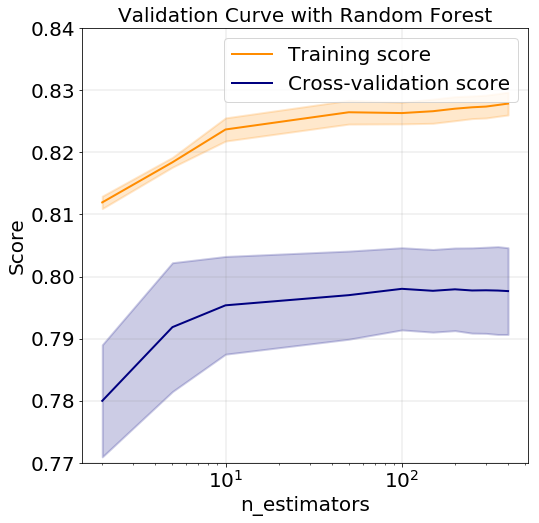

In [114]:
plt.figure(figsize=(8, 8))
param_range = [2, 5, 10, 50, 100, 150, 200, 250, 300, 350, 400]
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)
train_scores, test_scores = validation_curve(
    RandomForestClassifier(max_depth=9, random_state=17), data_woe, data['y'], param_name='n_estimators', param_range=param_range,
    cv=skf, scoring="roc_auc", n_jobs=-1)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with Random Forest")
plt.xlabel("n_estimators")
plt.ylabel("Score")
plt.ylim(0.77, 0.84)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.grid(color='grey', linestyle='-', linewidth=0.2)
plt.show()

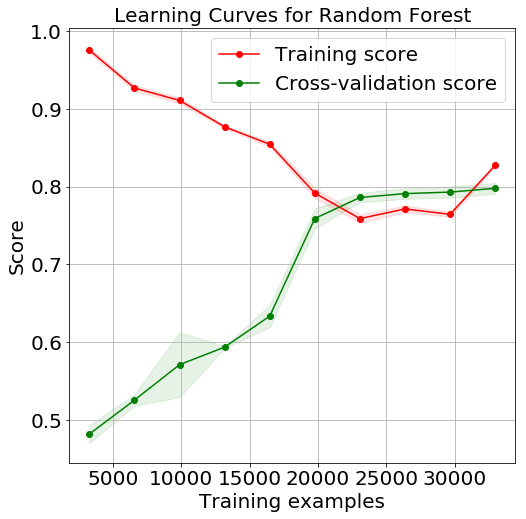

In [115]:
from sklearn.model_selection import learning_curve
plt.figure(figsize=(8, 8))

plt.title('Learning Curves for Random Forest')
plt.xlabel("Training examples")
plt.ylabel("Score")
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)
train_sizes, train_scores, test_scores = learning_curve(RandomForestClassifier(max_depth=9, n_estimators=290, random_state=17), data_woe, data['y'], cv=skf, n_jobs=1, train_sizes=np.linspace(.1, 1.0, 10), scoring='roc_auc')
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
plt.legend(loc="best")
plt.show()

Судя по кривой обучения, в целом, данных достаточно, но, видимо, некоторую прибавку качества за счёт увеличения датасета всё же можно было получить.  
Из кривой валидации видно, что основной рост качества происходит до 100 деревьев, далее качество меняется незначительно как в плюс так и в минус.

## Итог

Алгоритмы основанные на ансамблях деревьев показали себя очень хорошо, что не удивительно, учитывая, что мы считали WOE (т.е. создали разбиения, получив категориальные признаки для которых на значениях задана операция сравнения), данные не разреженные, размер датасета не маленький.  
При этом логистическая регрессия хоть и уступает, но показывает себя достаточно неплохо, т.е. при серьезной работе с ней, можно получать неплохие результаты, при этом интерпретируемые, что является большим плюсом для некоторых бизнес-задач.

Олег Акимов  
Slack: @Oleg  
LinkedIn: www.linkedin.com/in/oleg-akimov-715532102/ 